In [1]:
import numpy as np
import pandas as pd
import sys
!{sys.executable} -m pip install pandas_datareader
import pandas_datareader.data as web
import datetime as dt

You should consider upgrading via the 'C:\Users\rache\OneDrive\Desktop\CFRM\521\code\my_env\Scripts\python.exe -m pip install --upgrade pip' command.


In [2]:
!{sys.executable} -m pip install pyti
import technical_analysis as ta
import decision_profit as dp
import process_data as proc

You should consider upgrading via the 'C:\Users\rache\OneDrive\Desktop\CFRM\521\code\my_env\Scripts\python.exe -m pip install --upgrade pip' command.


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# data set up
# getting train, test, validation sets and corresponding dataframes containing closing prices and indicators
tickers = ['^GSPC', '^BSESN']
dfs = proc.get_process_df(tickers)
X_trains, X_tests, y_trains, y_tests, dfs_train, dfs_test = proc.get_train_test(dfs)
X_train_subs, X_vals, y_train_subs, y_vals, dfs_train_sub, dfs_val = proc.get_train_val(dfs_train, X_trains, y_trains)

In [5]:
names = ['S&P 500','BSE SENSEX']

# storing total extra profits achieved by each model
extra_profit_untuned = {}
extra_profit_msetune = {}
extra_profit_protune = {}

## Using default parameters ##

<h3> Support Vector Regressor 

In [6]:
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# adding scaler before SVR
models = []
for i in range(len(tickers)):
    models.append(Pipeline([('scaler', StandardScaler()), ('svr', SVR())]))

In [7]:
# train and training set summary
dp.train_and_summary(models, names, dfs_train, X_trains, y_trains)

Training set
S&P 500
number of trading positions taken with actual trend: 30
number of trading positions taken with predicted trend: 112
BSE SENSEX
number of trading positions taken with actual trend: 38
number of trading positions taken with predicted trend: 118
Training set
S&P 500
profit with actual trend: 40.402841277066365
profit with predicted trend: 92.59604665016755
BSE SENSEX
profit with actual trend: 12.228547748628062
profit with predicted trend: 42.438792982778125
average MSE: 0.030449866872565522


In [8]:
# test set summary
dp.test_summary(models, names, 'SVR', dfs_test, X_tests, y_tests, extra_profit_untuned, mse=True)

Test set
S&P 500
number of trading positions taken with actual trend: 9
number of trading positions taken with predicted trend: 29
BSE SENSEX
number of trading positions taken with actual trend: 4
number of trading positions taken with predicted trend: 22
Test set
S&P 500
profit with actual trend: 3.9777336540590267
profit with predicted trend: 14.479827631999376
BSE SENSEX
profit with actual trend: 30.466683849995118
profit with predicted trend: 28.447322251886572
Average MSE SVR 0.23375805782990988


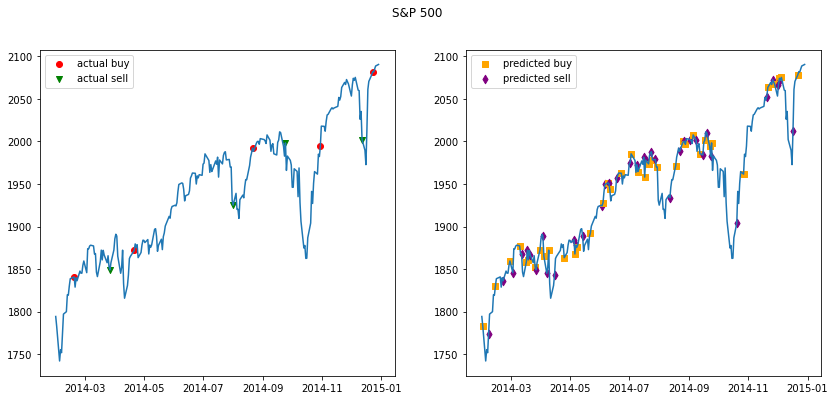

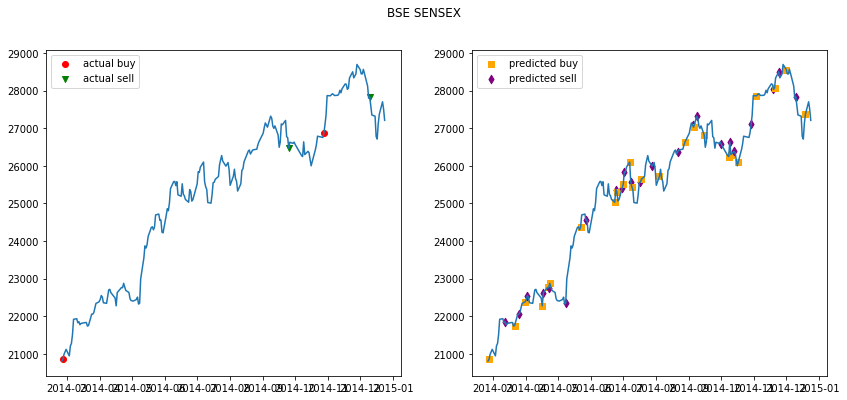

In [23]:
# trading activities

for i in range(2):
    dp.plot_signals(dfs_test[i], names[i])

## KNN ##

In [8]:
from sklearn.neighbors import KNeighborsRegressor

models = []
for i in range(len(tickers)):
    models.append(Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsRegressor())]))

# train and train set summary
dp.train_and_summary(models, names, dfs_train, X_trains, y_trains)

Training set
S&P 500
number of trading positions taken with actual trend: 30
number of trading positions taken with predicted trend: 126
BSE SENSEX
number of trading positions taken with actual trend: 38
number of trading positions taken with predicted trend: 132
Training set
S&P 500
profit with actual trend: 40.402841277066365
profit with predicted trend: 98.27511114432994
BSE SENSEX
profit with actual trend: 12.228547748628062
profit with predicted trend: 47.24193047878571
average MSE: 0.024357598608309595


In [29]:
dp.test_summary(models, names, 'KNN', dfs_test, X_tests, y_tests, extra_profit_untuned, mse=True)

Test set
S&P 500
number of trading positions taken with actual trend: 9
number of trading positions taken with predicted trend: 25
BSE SENSEX
number of trading positions taken with actual trend: 4
number of trading positions taken with predicted trend: 22
Test set
S&P 500
profit with actual trend: 3.9777336540590267
profit with predicted trend: 13.156348008848369
BSE SENSEX
profit with actual trend: 30.466683849995118
profit with predicted trend: 28.36706162154242
Average MSE KNN 0.20876160305174465


In [11]:
extra_profit_untuned

{'SVR': 8.482732379831804, 'KNN': 7.675783696460169}

## parameter tuning with cross validation ##

<h3> using MSE metric (find model that produces smallest mse)
    
<h3> SVR (adding polynomial degrees and pick the best gamma and kernel)

Notice: because I used time series split, the validation set will be grouped according to time and thee will only be one combination. Therefore, it is not possible to do multiple iterations so that the parameters will be found with only one iteration.

In [21]:
from sklearn.model_selection import cross_val_score
from scipy.stats import loguniform
from itertools import product
from sklearn.preprocessing import PolynomialFeatures

extra_profit1 = {}
Cs = loguniform.rvs(0.05, 5, size=10, random_state=42)
kernels = ['rbf', 'sigmoid']
ps = np.arange(1,6)
parameters = [ps, Cs, kernels]

param_list = list(product(*parameters))
best_params = []

for i in range(len(tickers)):
    best_param = []
    best_score = np.inf
    for param in param_list:
        pipe = Pipeline([('scaler', StandardScaler()), 
                         ('poly', PolynomialFeatures(degree=param[0])),
                          ('svr', SVR(C=param[1], kernel=param[2]))])
        score = dp.cv_mse(pipe, i, X_train_subs, y_train_subs, X_vals, y_vals)
        if score < best_score:
            best_score = score
            best_param = param
    best_params.append(best_param)
print("SVR parameters that yields smallest MSE for each security:", best_params)

SVR parameters that yields smallest MSE for each security: [(1, 0.7875660249889862, 'rbf'), (1, 0.7965261308120505, 'rbf')]


In [22]:
best_params = [(1, 0.7875660249889862, 'rbf'), (1, 0.7965261308120505, 'rbf')]

models = []
for i in range(len(tickers)):
    pipe = Pipeline([('scaler', StandardScaler()), 
                         ('poly', PolynomialFeatures(degree=best_params[i][0])),
                          ('svr', SVR(C=best_params[i][1], kernel=best_params[i][2]))])
    models.append(pipe.fit(X_trains[i], y_trains[i]))

print("SVR results using the parameters that yields the lowest MSE")
dp.test_summary(models, names, 'SVR', dfs_test, X_tests, y_tests, extra_profit_msetune, mse=True)

SVR results using the parameters that yields the lowest MSE
Test set
S&P 500
number of trading positions taken with actual trend: 9
number of trading positions taken with predicted trend: 29
BSE SENSEX
number of trading positions taken with actual trend: 4
number of trading positions taken with predicted trend: 22
Test set
S&P 500
profit with actual trend: 3.9777336540590267
profit with predicted trend: 14.479827631999376
BSE SENSEX
profit with actual trend: 30.466683849995118
profit with predicted trend: 28.36706162154242
Average MSE SVR 0.22909620382523987


<h3>KNN

In [30]:
from sklearn.neighbors import KNeighborsRegressor

# find the optimal number of neighbors
ks = np.arange(1, 20)
best_ks = []

for i in range(len(tickers)):
    best_k = 0
    best_score = np.inf
    for k in ks:
        pipe = Pipeline([('scaler', StandardScaler()),
                            ('knn', KNeighborsRegressor(n_neighbors=k))])        
        score = dp.cv_mse(pipe, i, X_train_subs, y_train_subs, X_vals, y_vals)
        if score < best_score:
            best_score = score
            best_k = k
    best_ks.append(best_k)
print("number of neighbors that yields lowest MSE for each security:", best_ks)

number of neighbors that yields lowest MSE for each security: [9, 8]


In [31]:
models = []
for i in range(len(tickers)):
    models.append(Pipeline([('scaler', StandardScaler()),
                            ('knn', KNeighborsRegressor(n_neighbors=best_ks[i]))]).fit(X_trains[i], y_trains[i]))
    
print("KNN results using the parameters that yields the lowest MSE")
dp.test_summary(models, names, 'KNN', dfs_test, X_tests, y_tests, extra_profit_msetune, mse=True)

KNN results using the parameters that yields the lowest MSE
Test set
S&P 500
number of trading positions taken with actual trend: 9
number of trading positions taken with predicted trend: 25
BSE SENSEX
number of trading positions taken with actual trend: 4
number of trading positions taken with predicted trend: 22
Test set
S&P 500
profit with actual trend: 3.9777336540590267
profit with predicted trend: 13.156348008848369
BSE SENSEX
profit with actual trend: 30.466683849995118
profit with predicted trend: 28.36706162154242
Average MSE KNN 0.21652080599883078


In [15]:
extra_profit_msetune

{'SVR': 8.40247174948765, 'KNN': 7.078992126336644}

<h3> results with 0 MSE

In [6]:
profits_0 = []
for i in range(2):
    df = dfs_test[i].copy()
    trend_best = ta.predicted_trend(df, df['tr'].values)
    df['trend_pred'] = trend_best
    pa = dp.trading_decision(df['trend'].values)
    pp = dp.trading_decision(df['trend_pred'].values)
    df['actual position'] = pa
    df['predicted position'] = pp
    pro_a = dp.profit_calculation(df, actual=True)
    pro_p = dp.profit_calculation(df)
    profits_0.append(pro_p - pro_a)

In [7]:
profits_0

[7.643704434895284, -1.8699846031119485]

In [8]:
np.sum(profits_0)

5.773719831783335

Notice that low MSE does not necessarily lead to higher profit, which may be due to the inadequacy of the strategy. Therefore, I will try to find the best parameters that yield the highest profit on the validation set. 

<h3> using profit metrics

<h3> SVR

In [33]:
best_params1 = []

for i in range(len(tickers)):
    best_profit = 0
    for param in param_list:
        profit = dp.cv_profit(pipe, i, dfs_train_sub, dfs_val, X_train_subs, y_train_subs, X_vals, y_vals)
        if profit > best_profit:
            best_profit = profit
            best_param = param
    best_params1.append(best_param)
print("SVR parameters that yield the highest profit on each security:", best_params1)

SVR parameters that yield the highest profit on each security: [(1, 0.2805758207667252, 'rbf'), (1, 0.2805758207667252, 'rbf')]


In [32]:
models = []
for i in range(len(tickers)):
    pipe = Pipeline([('scaler', StandardScaler()), 
                         ('poly', PolynomialFeatures(degree=best_params1[i][0])),
                          ('svr', SVR(C=best_params1[i][1], kernel=best_params1[i][2]))])
    models.append(pipe.fit(X_trains[i], y_trains[i]))

print("SVR results using the parameters that yields highest profit")
dp.test_summary(models, names, 'SVR', dfs_test, X_tests, y_tests, extra_profit_protune, mse=True)

SVR results using the parameters that yields highest profit
Test set
S&P 500
number of trading positions taken with actual trend: 9
number of trading positions taken with predicted trend: 75
BSE SENSEX
number of trading positions taken with actual trend: 4
number of trading positions taken with predicted trend: 47
Test set
S&P 500
profit with actual trend: 3.9777336540590267
profit with predicted trend: 2.1312616298783222
BSE SENSEX
profit with actual trend: 30.466683849995118
profit with predicted trend: 19.261617140743255
Average MSE SVR 26.436734093509507


In [26]:
best_ks1 = []
ks = np.arange(1, 20)

best_param = []
for i in range(len(tickers)):
    best_k = 0
    best_profit = 0
    for k in ks:
        profit = 0
        pipe = Pipeline([('scaler', StandardScaler()),
                            ('knn', KNeighborsRegressor(n_neighbors=k))])          
        profit = dp.cv_profit(pipe, i, dfs_train_sub, dfs_val, X_train_subs, y_train_subs, X_vals, y_vals)
        if profit > best_profit:
            best_profit = profit
            best_k = k
    best_ks1.append(best_k)
print("number of neighbors that yields the highest profit for each security:", best_ks)

number of neighbors that yields the highest profit for each security: [9, 8]


In [34]:
models = []
for i in range(len(tickers)):
    models.append(Pipeline([('scaler', StandardScaler()),
                            ('knn', KNeighborsRegressor(n_neighbors=best_ks1[i]))]).fit(X_trains[i], y_trains[i]))

print("KNN results using the parameters that yields the lowest MSE")
dp.test_summary(models, names, 'KNN', dfs_test, X_tests, y_tests, extra_profit_protune, mse=True)

KNN results using the parameters that yields the lowest MSE
Test set
S&P 500
number of trading positions taken with actual trend: 9
number of trading positions taken with predicted trend: 25
BSE SENSEX
number of trading positions taken with actual trend: 4
number of trading positions taken with predicted trend: 22
Test set
S&P 500
profit with actual trend: 3.9777336540590267
profit with predicted trend: 13.156348008848369
BSE SENSEX
profit with actual trend: 30.466683849995118
profit with predicted trend: 28.36706162154242
Average MSE KNN 0.20876160305174465


In [28]:
extra_profit_protune

{'SVR': -13.051538733432567, 'KNN': 7.078992126336644}

profit is much lower with tuned parameters for SVR.